In [429]:
#| echo: false
#| export
from fastai.basics import *
from fastai.vision.models.unet import *
from fastai.vision.all import *
from fastai.torch_basics import *
from denoising_diffusion_pytorch import Unet
from fastai.callback.wandb import _make_plt
from torch import autocast
from fastcore.transform import _is_tuple
from fastai.vision.gan import InvisibleTensor,generate_noise

We create two new Tensor Types, one for our noise, and one for our timestep. 

In [430]:
class TensorNoise(TensorImageBase):pass
class TensorStep(TensorBase): pass

We would like normalize to denormalize our noise before showing it. This is so the noise in our image looks similar to the noise in our noised image. 

In [431]:
@Normalize
def decodes(self, x:TensorNoise):
    f = to_cpu if x.device.type=='cpu' else noop
    return (x*f(self.std) + f(self.mean))

In [432]:
#| echo: false
path = untar_data(URLs.IMAGENETTE_320)
img = Image.open(path.ls()[0].ls()[3].ls()[0])
norm = Normalize.from_stats(*imagenet_stats)
img = norm(TensorImage(image2tensor(img)[None]/255.).to(device='cuda'))

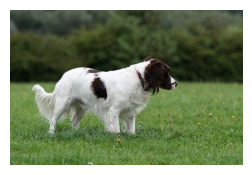

In [433]:
norm = Normalize.from_stats(*imagenet_stats)
show_images(norm.decode(img))

I patch ItemTransform here, so that it can work off of TypedTuples. Essentially if we have a `DiffusionTuple`, the transform will apply to that if it should apply to that type of tuple. 

In [460]:
class ItemTransform(Transform):
    "A transform that always take tuples as items"
    _retain = True
    # Only showing important code
    def _call_tuple(self:ItemTransform, name, x, split_idx=None, **kwargs):
        f = getattr(super(), name)
        f2name='encodes' if name == '__call__' else 'decodes' if name == 'decode' else name
        f2 = getattr(self, f2name)
        if isinstance(f2,TypeDispatch) and f2[type(x)] is not None:
            if split_idx!=self.split_idx and self.split_idx is not None: return x
            y = f2(x, **kwargs)
        else:
            y = f(list(x), **kwargs)
        return y

In [461]:
#| echo: false
class ItemTransform(Transform):
    "A transform that always take tuples as items"
    _retain = True
    def __call__(self, x, **kwargs): return self._call1(x, '__call__', **kwargs)
    def decode(self, x, **kwargs):   return self._call1(x, 'decode', **kwargs)
    def _call1(self:ItemTransform, x, name, **kwargs):
        if not _is_tuple(x): return getattr(super(), name)(x, **kwargs)
        y=self._call_tuple(name,x,**kwargs)
        if not self._retain: return y
        if is_listy(y) and not isinstance(y, tuple): y = tuple(y)
        return retain_type(y, x)
    def _call_tuple(self:ItemTransform, name, x, split_idx=None, **kwargs):
        f = getattr(super(), name)
        f2name='encodes' if name == '__call__' else 'decodes' if name == 'decode' else name
        f2 = getattr(self, f2name)
        if isinstance(f2,TypeDispatch) and f2[type(x)] is not None:
            if split_idx!=self.split_idx and self.split_idx is not None: return x
            y = f2(x, **kwargs)
        else:
            y = f(list(x), **kwargs)
        return y

The general idea is to implement a named tuple, and use duck typing. In the future, we should look at the named tuple class and do something more similar to that. 

In [462]:
class DiffusionTuple(fastuple):
    def __new__(cls, *rest):
        self=super().__new__(cls, *rest)
        i=0
        self.x=self[i]
        if(isinstance(self[i+1],TensorImage)): self.x0=self[i:=i+1]
        self.t=self[i:=i+1]
        if(len(self)>i+1): self.y=self[i:=i+1]
        if(len(self)>i+1): self.pred=self[i:=i+1]
        return self

In [463]:
#| echo: false
@patch
def show(self:DiffusionTuple, ctx=None, show_noise=False,**kwargs): 
    line = self.x.new_zeros((*self.x.shape[:-1], 10)).long()
    imgs = []
    for im in self[:]: 
        if isinstance(im,TensorImage) or (isinstance(im,TensorNoise) and show_noise): 
            # must all be of same scale
            if im.dtype.is_floating_point: im=(im* 256).long() 
            imgs+=[line,TensorBase(im.clamp(0, 255))]
    imgs=torch.cat(imgs[1:], dim=self.x.ndim-1)

    if imgs.ndim>3: imgs=imgs[0]
    return show_image( imgs, title=self.t, ctx=ctx, **kwargs)

A little transform to make our tuple a `DiffusionTuple`

In [464]:
class ToDiffusionTuple(ItemTransform):
    order=100
    def encodes(self,xy):
        return DiffusionTuple(*xy[:-1],TensorNoise(xy[-1]))

This `Transform` expects y to contain an image, and just replaces it with noise. Our model tries to predict the noise in an image. 

In [465]:
class LabelToNoise(ItemTransform):
    order=101
    def encodes(self,xy:DiffusionTuple):
        y=xy.y
        xy.y[:]=TensorNoise(torch.randn_like(y))
        return xy

In [466]:
diff_tuple=LabelToNoise.encodes(DiffusionTuple(img[0].detach().clone(),TensorStep(torch.tensor([[200]])),TensorNoise(img[0].clone())))

We can access tuple elements by attributes. This is useful when you don't know what index a particular value is located. 

In [467]:
diff_tuple.x.shape,diff_tuple.t.shape,diff_tuple.y.shape

(torch.Size([3, 320, 480]), torch.Size([1, 1]), torch.Size([3, 320, 480]))

Now we have a way to create an image, and convert the label to noise. 

<AxesSubplot:title={'center':'TensorStep([[200]])'}>

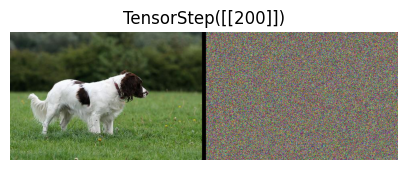

In [468]:
norm.decode(diff_tuple).show(show_noise=True)

Next, we need to go create a noised image, to pass to our model. 

In [469]:
class Diffusion_P_Sampler():
    def __init__(self,model,sampling_function):
        self.device=sampling_function.device
        self.model=model
        self.sampling_function=sampling_function
    # __call__ implemented, but not shown.
    def iter_noise(self,x_t,ts,t_start):
        i=0
        while((ts>0).any()):
            x,t=x_t[ts>0],ts[ts>0]
            with autocast(device_type=self.device, dtype=x.dtype):
                with torch.no_grad(): 
                    e = self.model(x,self.deconvert(t) if i!=0 else t_start)
                x_t[ts>0]=self.sampling_function(x,e,t,t=t_start if i==0 else None)
            ts[ts>0]-=1
            i+=1
            yield x_t

In [470]:
#| echo: false
@patch
def __call__(self:Diffusion_P_Sampler,x,ts=None):
    if ts is None: ts=(self.sampling_function.ns.n_steps-1)*torch.ones([x.shape[0],1],device=x.device,dtype=torch.long)
    t_start=TensorBase(ts.flatten())
    ts = self.sampling_function.convert(t_start)
    for xt in self.iter_noise(x,ts,t_start): x=xt
    return x
@patch
def convert(self:Diffusion_P_Sampler,ns_t): return self.sampling_function.convert(ns_t)
@patch
def deconvert(self:Diffusion_P_Sampler,ns_t): return self.sampling_function.deconvert(ns_t)

Next we need to know how much noise to apply to each step.

In [471]:
class LinearNoiseSchedule:
    "Schedule like used in DDPM"
    def __init__(self,betas=None,n_steps=None,device='cuda'):
        if betas is not None: self.n_steps=betas.shape[0]
        if n_steps is None: self.n_steps=1000
        if betas is None: self.betas = torch.linspace(0.0001, 0.02, self.n_steps,device=device)
        self.alphas = 1. - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)

Lets graph the various values here, in order to see what happens. Pay particularly close attention to `alpha_bar` as that controls the balance betwen our signal(image) and our noise. 

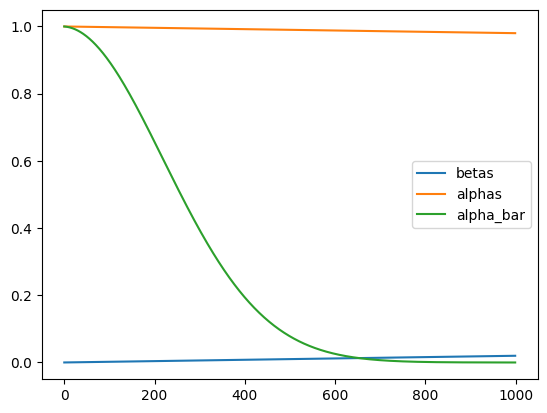

In [472]:
lns=LinearNoiseSchedule()
plt.plot((lns.betas).cpu())
plt.plot((lns.alphas).cpu())
plt.plot((lns.alpha_bar).cpu())
plt.legend(['betas', 'alphas','alpha_bar'])

Next is DDPM-style Q-sampling. This is pretty much used for all diffusion models, and is the process that takes us from and image to noise. 

In [473]:
class DDPM_Q_Sampling():
    def __init__(self,predicts_x=False,noise_schedule=LinearNoiseSchedule(),n_steps=1000,device='cuda'):
        self.device=device
        self.ns=noise_schedule
        self.n_steps=n_steps
        self.t_sched=torch.linspace(0,len(self.ns.alpha_bar)-1,n_steps,dtype=torch.long)[...,None,None,None]
    def __call__(self,x,es,t):
        t=self.t_sched[t]
        a=self.ns.alpha_bar[t].to(device=x.device)
        signal = (a ** .5)*x
        noise = (1-a)**.5 * es
        return signal + noise

In [476]:
#| echo: false
class DiffusionSamplingTransform(ItemTransform):
    order=101
    "noise_sampler, or q_sampler, goes to noise at t=T. image sampler, p_sampler, goes to image at t=0"
    def __init__(self,noise_sampler,image_sampler):
        self.q_sample=noise_sampler
        self.p_sample=image_sampler
    def encodes(self,xy:DiffusionTuple):
        y=xy.y
        ts = xy.t[:,0]
        x=self.q_sample(xy.x, TensorBase(xy.y),TensorBase(ts),)
        xy.x[:]=x[:]
        return xy
    def decodes(self,xy:DiffusionTuple):
        ts = type(xy.x)(xy.t)
        xy.y[:] = TensorNoise(self.p_sample(xy.x.clone().detach().cuda(),xy.t.clone().detach().cuda()))[:]
        return xy

In [492]:
diff_trans = DiffusionSamplingTransform(DDPM_Q_Sampling(),lambda x:x)

<AxesSubplot:title={'center':'TensorStep([[200]])'}>

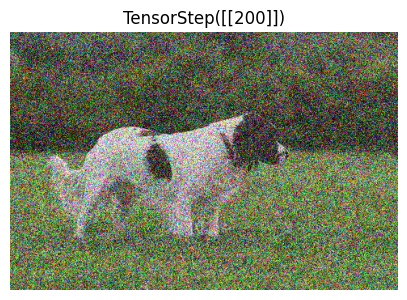

In [493]:
norm.decode(diff_trans(diff_tuple)).show()

Lets now test so make sure our noise is being generated correctly.

In [494]:
noise_tuple=LabelToNoise.encodes(DiffusionTuple(img[0].detach().clone(),TensorStep(torch.tensor([[999]])),TensorNoise(img[0].clone())))

<AxesSubplot:title={'center':'TensorStep([[999]])'}>

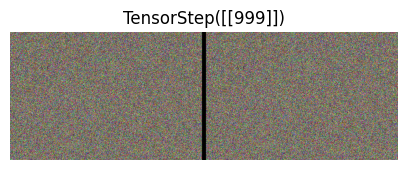

In [495]:
norm.decode(diff_trans(noise_tuple)).show(show_noise=True)

These are not exactly the same as it is one noising step, but they are fairly close. 

In [496]:
is_close(norm.decode(diff_trans(noise_tuple))[0],TensorImage(norm.decode(diff_trans(noise_tuple))[2]),eps=1e-02)

TensorImage(True, device='cuda:0')

### Going from noise to and image, p_sampling

In [499]:
#| echo: false
class DDPM_P_Sampling():
    def __init__(self,predicts_x=False,noise_schedule=LinearNoiseSchedule(),n_steps=1000,device='cuda'):
        self.device=device
        self.ns=noise_schedule
        self.n_steps=n_steps
        self.t_sched=torch.linspace(0,len(self.ns.alpha_bar)-1,n_steps,dtype=torch.long)[...,None,None,None]
        if(predicts_x): raise NotImplementedError()
    def convert(self,ns_t): return ns_t
    def deconvert(self,ns_t): return self.t_sched[ns_t].to(device=ns_t.device).flatten()

In [500]:
@patch
def __call__(self:DDPM_P_Sampling,x,es,ns_t,t=None):
    t= self.t_sched[ns_t] if(t is None) else t[...,None,None,None]
    n=torch.randn_like(x)
    e,a,b=self._noise_at_t(es,t),self.ns.alphas[t],self.ns.betas[t]
    signal = (x - e) / (a ** 0.5)
    noise = b**.5 * n
    return signal + noise
@patch
def _noise_at_t(self:DDPM_P_Sampling,es,t):
    eps_coef = (1 - self.ns.alphas[t]) / (1 - self.ns.alpha_bar[t]) ** .5 
    return eps_coef* es

We implement DDIM sampling here, as it drastically reduces sampling time from 1000 steps to 50. Just generally helps us keep our sanity when trying to show our results. 

In [501]:
#| echo: false
class DDIM_P_Sampling():
    def __init__(self,predicts_x=False,n_steps=50,noise_schedule=LinearNoiseSchedule(),device='cuda'):
        self.predicts_x=predicts_x
        self.device=device
        self.ns=noise_schedule
        self.n_steps=n_steps
        self.t_sched=torch.linspace(0,self.ns.n_steps-1,n_steps,dtype=torch.long)
    def convert(self,ns_t): return ns_t*(self.n_steps-1)//self.ns.n_steps+1
    def deconvert(self,ns_t): return self.t_sched[ns_t].to(device=ns_t.device)

In [502]:
@patch
def __call__(self:DDIM_P_Sampling,z,es,ns_t,t=None):
    if(t is None): t=self.t_sched[ns_t]
    tp1=self.t_sched[ns_t-1]
    a,a_tp1=self.ns.alpha_bar[t][...,None,None,None],self.ns.alpha_bar[tp1][...,None,None,None]
    if self.predicts_x: 
        xs=es
        es=(z - (a)**.5 * xs)/(1-a)**.5
    else: xs=(z - (1-a)**.5 * es)/ (a ** .5)
    signal = a_tp1**.5*(xs) 
    noise = (1-a_tp1)**.5*es
    return signal + noise

### Training a model

In [24]:
path = untar_data(URLs.CIFAR)

In [25]:
m=Unet(dim=192+192//8,channels=3,).cuda()

In [26]:
#| echo: false
@typedispatch
def show_batch(x:DiffusionTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(3*min(len(x[0]), max_n), nrows=nrows, ncols=3, figsize=figsize, title='Input/Original/Target')
    for i,ctx in enumerate(ctxs): DiffusionTuple(x[0][i], x[1][i], x[2][i].item(),x[3][i]).show(ctx=ctx)

In [27]:
#| echo: false
class FlattenCallback(Callback):
    order=1 #after GatherPredsCallback
    #Maybe done for specific model? 
    def before_batch(self):
        self.xbo=self.xb
        self.learn.xb=(self.xb[0],self.xb[-1].view(self.xb[-1].shape[::2]),)
    def after_batch(self):
        self.learn.xb=self.xbo

In [28]:
#| echo: false
@typedispatch
def show_results(x:DiffusionTuple, y, samples, outs, ctxs=None, max_n=10, figsize=None,**kwargs):
    if ctxs is None: ctxs = get_grid(min(len(x[0]), max_n), ncols=4, figsize=figsize, title='Input/Original/DenoisedImage')
    for i,ctx in enumerate(ctxs): 
        DiffusionTuple(x[0][i], x[1][i], x[2][i].item(),x[3][i],TensorImage(y[-1][i]),
                      ).show(ctx=ctx,**kwargs)
    return ctxs

In [29]:
#| echo: false
@typedispatch
def show_batch(x:DiffusionTuple, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(3*min(len(x[0]), max_n), nrows=nrows, ncols=3, figsize=figsize, title='Input/Original/Target')
    for i,ctx in enumerate(ctxs): DiffusionTuple(x[0][i], x[1][i], x[2][i].item(),x[3][i]).show(ctx=ctx)

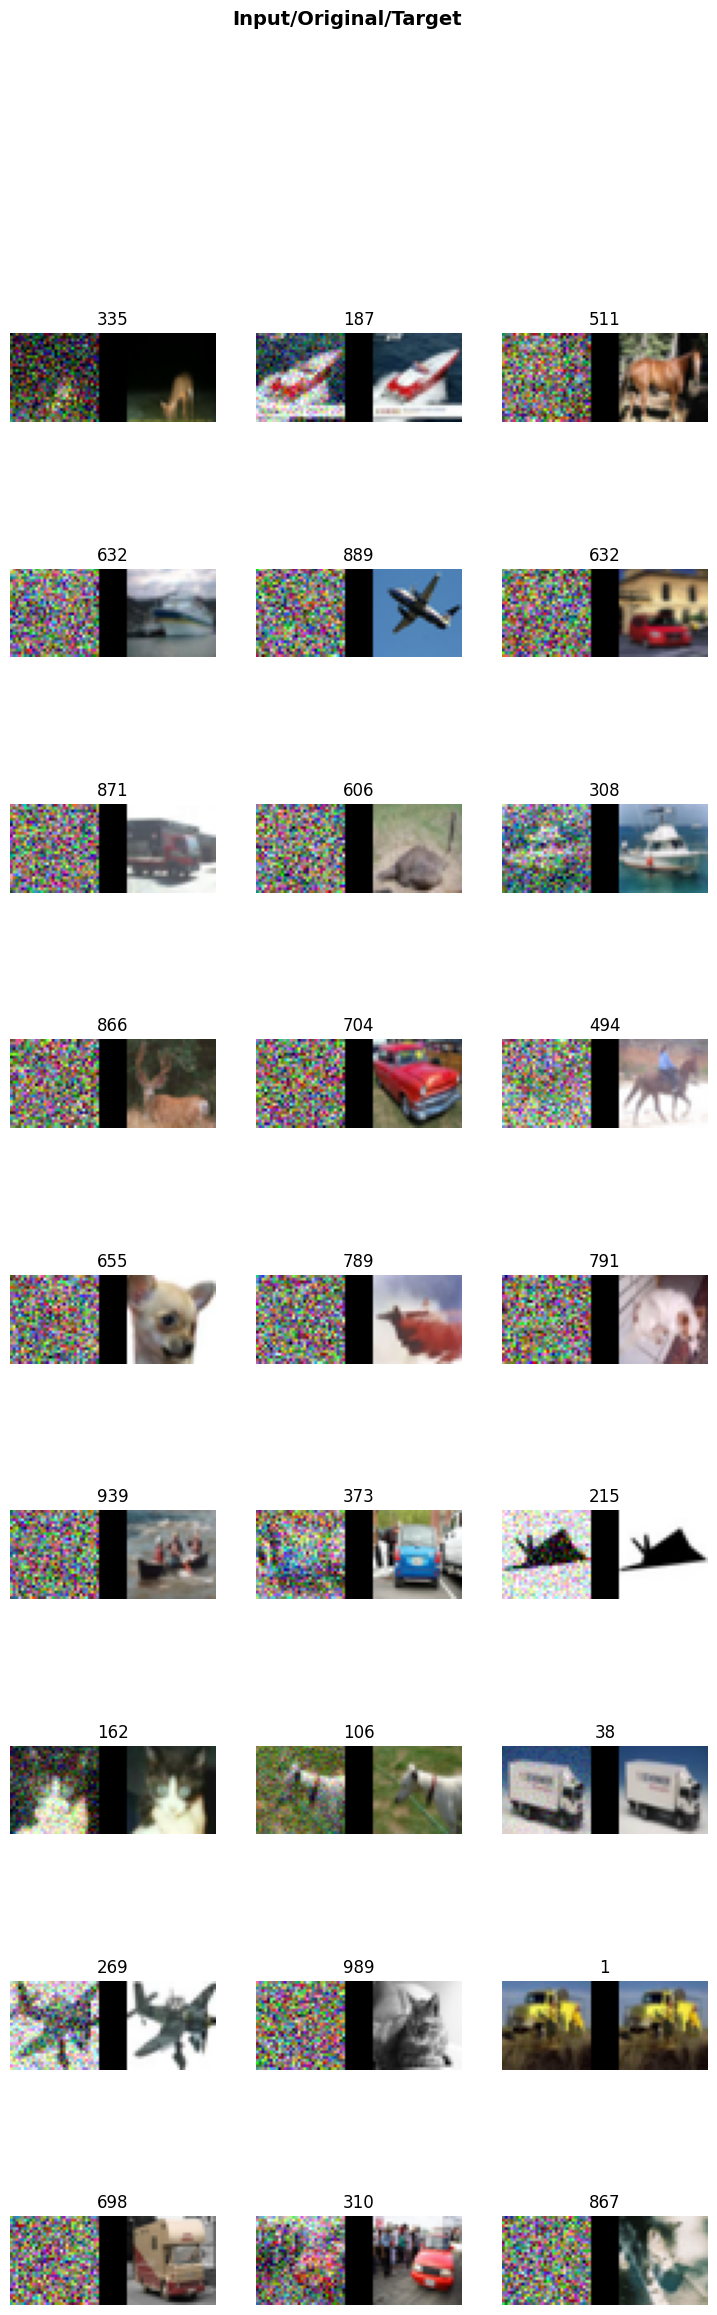

In [403]:
bs=128
n_steps=1000
diffusion_transform = DiffusionSamplingTransform(DDPM_Q_Sampling(),Diffusion_P_Sampler(m,DDPM_P_Sampling()))
dls=DataBlock((ImageBlock(),
               ImageBlock(),
               TransformBlock(type_tfms=[DisplayedTransform(enc=lambda o: TensorStep(o))]),
               ImageBlock()),
          n_inp=3,
          item_tfms=[Resize(32)],
          batch_tfms=(Normalize.from_stats(*cifar_stats),ToDiffusionTuple,LabelToNoise,diffusion_transform),
          get_items=get_image_files,
          get_x=[lambda x:x,lambda x:x,
                 lambda x: torch.randint(1, n_steps, (1,), dtype=torch.long)],
          splitter=IndexSplitter(range(bs)),
).dataloaders(path,bs=bs,val_bs=2*bs)
dls.show_batch()

In [32]:
def mse_loss_weighted(ys,targ):
    return torch.mean(targ.w_sched[...,None] * ((ys - targ).flatten(start_dim=1) ** 2))

In [33]:
#| echo: true
def snr(at): return at/(1-at)

In [34]:
def continuous_weights(at):
    weights = -snr(at[1:])/(snr(at[1:])-snr(at[:-1]))
    return torch.cat((weights[0:1],weights))

In [35]:
class WeightedLinSched(Callback):
    def after_pred(self):
        if(not hasattr(self,'ws')):
            self.ws = continuous_weights(LinearNoiseSchedule().alpha_bar).clip(min=1)
            self.ws /= self.ws.mean()
        ts=self.learn.xb[1].flatten()
        self.learn.yb[0].w_sched=self.ws[ts]

In [37]:
learn = Learner(dls,m,mse_loss_weighted,opt_func=Adam,cbs=[FlattenCallback,WeightedLinSched])
learn = learn.to_fp16()
learn.fit_flat_cos(10,lr=2e-4,wd=0.)

epoch,train_loss,valid_loss,time
0,0.049789,0.042322,04:39
1,0.044212,0.039284,04:39
2,0.041315,0.045253,04:40
3,0.040457,0.038427,04:39
4,0.039394,0.035517,04:40
5,0.039198,0.039416,04:39
6,0.039298,0.037537,04:39
7,0.038256,0.040432,04:39
8,0.038232,0.025152,04:40
9,nan,0.036510,04:38


next check show_results

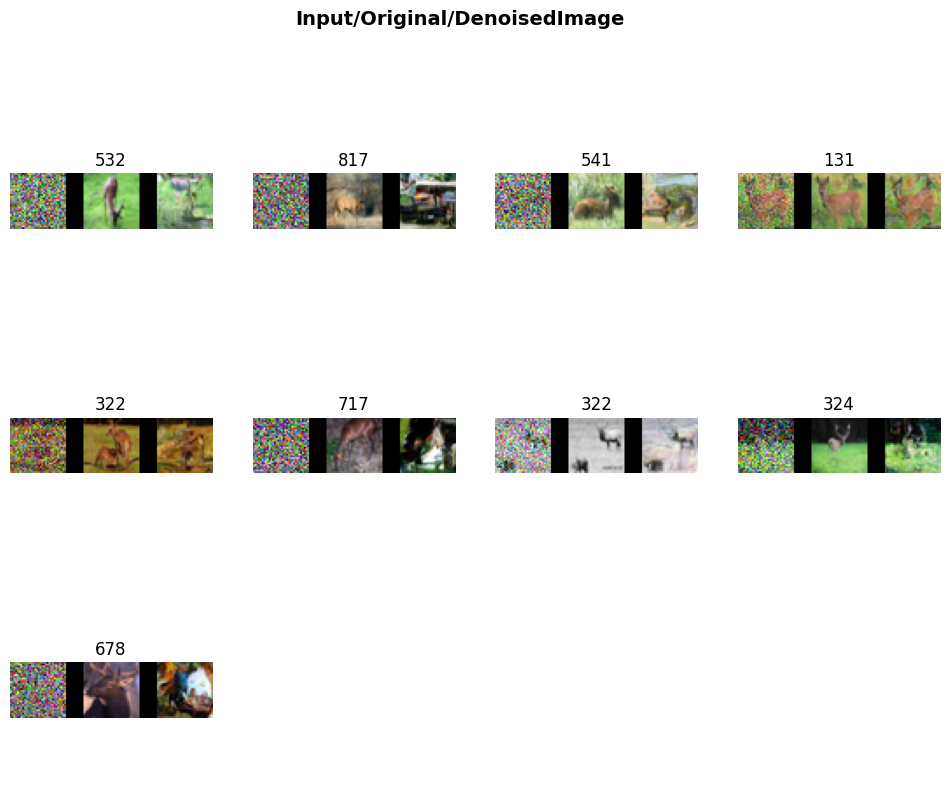

In [405]:
learn.show_results()